In [ ]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np

data_dir = "/vol/biomedic3/bglocker/radiotherapy/kat100/nifti"

In [2]:
sample_names = sorted(os.listdir(data_dir))
train_set = sample_names[:80]
test_set = sample_names[81:]

/vol/bitbucket/djk18/rank_10_mc_20_patch_110_cervical_2m_iso/test/predictions/zzAMLART081_prob_maps.nii.gz
(250, 250, 250)
(2.0, 2.0, 2.0)
[4.14291196e-36 3.56980251e-38 3.46023527e-38 ... 2.93685779e-28
 4.08350743e-29 2.42204011e-28]
(250, 250, 250, 9)


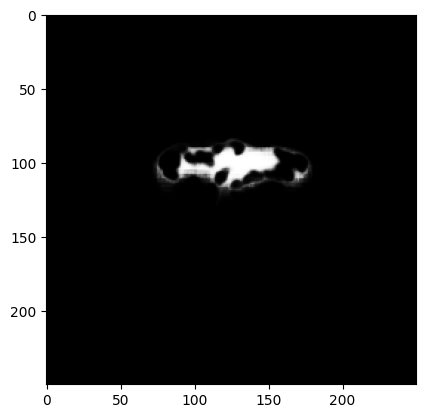

In [3]:
def display_probability_map(img_path):
    print(img_path)
    img = sitk.ReadImage(img_path) 
    # for key in img.GetMetaDataKeys():
    #     print(key + " : " + img.GetMetaData(key))

    print(img.GetSize())
    print(img.GetSpacing())
    img_array = sitk.GetArrayFromImage(img) # Convert the SimpleITK image to a NumPy array
    print(img_array[np.logical_and(img_array > 0, img_array < 1)])
    print(img_array.shape)
    plt.imshow(img_array[150,:,:, 6], cmap='gray')

display_probability_map("/vol/bitbucket/djk18/rank_10_mc_20_patch_110_cervical_2m_iso/test/predictions/zzAMLART081_prob_maps.nii.gz")

In [5]:
# # Convert create thresholded samples


    
def labels_to_masks(pred_dir, patient_list, threshold_prob):
    masks = ["Bones", "FemoralHead_L", "FemoralHead_R", "Bladder", "Anorectum", "Bowel-bag", "Bowel-loops", "CTVp"]
    regions = {"Bones" : ["Bones", "FemoralHead_L", "FemoralHead_R"], "Bowel-bag" : ["Bowel-bag", "Bowel-loops"]}
    
    for patient in patient_list:
       output_dir = os.path.join(pred_dir, "threshold", patient)

       if not os.path.exists(output_dir):
          os.makedirs(output_dir)

       prob_map_path = os.path.join(pred_dir, patient + "_prob_maps.nii.gz")

       prob_map = nib.load(prob_map_path)
       prob_map_header = prob_map.header.copy()
       prob_map_arr = np.array(prob_map.dataobj)
      

       for i in range(len(masks)):
           if (int(i) != 0):
            mask_name = masks[int(i) - 1]
            bit_map = np.zeros(prob_map.shape, dtype=np.dtype('u1'))
            print(prob_map_arr.shape)
            bit_map[prob_map_arr[i,:,:,:] >= threshold_prob] = 255 #int(i)

            #Add other substructures to bit map
            if mask_name in regions:
                for sub_class in regions[mask_name]:
                    sub_id = masks.index(sub_class)
                    bit_map[prob_map_arr == int(sub_id + 1)] = 255
                
            ni_img = nib.Nifti1Image(bit_map, None, header=prob_map_header)
            nib.save(ni_img, os.path.join(output_dir, "mask_" + mask_name + str(threshold_prob) + ".nii.gz"))


def fill_contour_holes(bitmap):
    contours, hierarchy = cv2.findContours(bitmap.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_bitmap = bitmap.copy()

    for contour in contours:
        cv2.drawContours(filled_bitmap, [contour], 0, 255, -1)

    return filled_bitmap

labels_to_masks("/vol/bitbucket/djk18/rank_10_mc_20_patch_110_cervical_2m_iso/test/predictions", ["zzAMLART081"], 0.3)
      

In [2]:

def plot_probability_distribution(prob_map):
    # Flatten the probability map to a 1D array
    prob_array = np.ravel(prob_map)

    # Plot the probability distribution
    plt.hist(prob_array, bins=200, range=(0.9, 1), density=True)
    plt.title("Probability Distribution")
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.show()



In [7]:
import os
import SimpleITK as sitk

def threshold(pred_dir, patient_list, threshold_prob):
    masks = ["Bones", "FemoralHead_L", "FemoralHead_R", "Bladder", "Anorectum", "Bowel-bag", "Bowel-loops", "CTVp"]
    regions = {"Bones": ["Bones", "FemoralHead_L", "FemoralHead_R"], "Bowel-bag": ["Bowel-bag", "Bowel-loops"]}

    for patient in patient_list:
        output_dir = os.path.join(pred_dir, "threshold", patient)

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        prob_map_path = os.path.join(pred_dir, patient + "_prob_maps.nii.gz")

        prob_map = sitk.ReadImage(prob_map_path)
        prob_map_arr = sitk.GetArrayFromImage(prob_map)

        for i in range(len(masks)):
            if i != 0:
                mask_name = masks[i - 1]
                bit_map = sitk.GetImageFromArray(np.zeros(prob_map_arr.shape, dtype=np.uint8))
                bit_map.CopyInformation(prob_map)

                bit_map_arr = sitk.GetArrayFromImage(bit_map)
                # bit_map_arr[bit_map_arr > 0]
                #plot_probability_distribution(prob_map)
                bit_map_arr[prob_map_arr[:, :, :, i] >= threshold_prob] = 255


                # # Plot the image
                # plt.imshow(bit_map_arr[0, :, :], cmap='gray')  # Assuming 3D image, adjust indexing if necessary
                # plt.axis('off')
                # plt.title("Thresholded Image - {}".format(mask_name))
                # plt.show()


                # Add other substructures to bit map
                # if mask_name in regions:
                #     for sub_class in regions[mask_name]:
                #         sub_id = masks.index(sub_class)
                #         bit_map_arr[prob_map_arr == int(sub_id + 1)] = 255

                ni_img = sitk.GetImageFromArray(bit_map_arr)
                
                ni_img.CopyInformation(prob_map)
                sitk.WriteImage(ni_img, os.path.join(output_dir, "mask_" + mask_name + str(threshold_prob) + ".nii.gz"))

threshold("/vol/bitbucket/djk18/rank_10_mc_20_patch_110_cervical_2m_iso/test/predictions", ["zzAMLART081"], 0.9)

#threshold("/vol/bitbucket/djk18/cervical_Task16_1050/test/predictions", ["zzAMLART081"], 0.9)

In [11]:

# def threshold(pred_dir, patient_list, threshold_prob):
#     masks = ["Bones", "FemoralHead_L", "FemoralHead_R", "Bladder", "Anorectum", "Bowel-bag", "Bowel-loops", "CTVp"]
#     regions = {"Bones": ["Bones", "FemoralHead_L", "FemoralHead_R"], "Bowel-bag": ["Bowel-bag", "Bowel-loops"]}

#     for patient in patient_list:
#         output_dir = os.path.join(pred_dir, "threshold", patient)

#         if not os.path.exists(output_dir):
#             os.makedirs(output_dir)

#         prob_map_path = os.path.join(pred_dir, patient + "_prob_maps.nii.gz")

#         prob_map = sitk.ReadImage(prob_map_path)
#         prob_map_arr = sitk.GetArrayFromImage(prob_map)

#         for i in range(len(masks)):
#             if i != 0:
#                 mask_name = masks[i - 1]

#                 # Threshold the class probability map
#                 class_prob_map = prob_map_arr[:, :, :, i]
#                 class_thresholded_map = np.zeros_like(class_prob_map, dtype=np.uint8)
#                 class_thresholded_map[class_prob_map >= threshold_prob] = 255

#                 if mask_name in regions:
#                     for sub_class in regions[mask_name]:
#                         sub_id = masks.index(sub_class)
#                         class_thresholded_map[class_prob_map == sub_id + 1] = 255

           

#                 ni_img = sitk.GetImageFromArray(class_thresholded_map)
#                 ni_img.CopyInformation(prob_map)
#                 sitk.WriteImage(ni_img, os.path.join(output_dir, "mask_" + mask_name + str(threshold_prob) + ".nii.gz"))

#                 # plt.imshow(class_thresholded_map[:, 100, :], cmap='gray')  # Assuming 3D image, adjust indexing if necessary
#                 # plt.axis('off')
#                 # plt.title("Thresholded Image - {}".format(mask_name))
#                 # plt.show()


# threshold("/vol/bitbucket/djk18/rank_10_mc_20_patch_110_cervical_2m_iso/test/predictions", ["zzAMLART081"], 0.9)